# Instacart Market Basket Analysis: Customer Segmentation
*Date: 2025-05-09*  

**Objective**: Segment Instacart customers into distinct behavioral-demographic clusters for targeted marketing.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import os
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading & Preprocessing

In [3]:
# Set path
path = r'~/Data/'
# Load datasets (adjust paths as needed)
orders = pd.read_csv(os.path.join(path, 'orders.csv'))
order_products = pd.read_csv(os.path.join(path, 'orders_products_prior.csv'))
products = pd.read_csv(os.path.join(path, 'products.csv'))
departments = pd.read_csv(os.path.join(path, 'departments.csv'))
customer = pd.read_csv(os.path.join(path, 'customers.csv'))

In [5]:
# Merge datasets
df = orders.merge(order_products, on='order_id').merge(products, on='product_id')

## 2. Exploratory Data Analysis

#### Key Questions:

 * What are the best-selling products?
 * When do customers spend the most money?
 * When are the best times to schedule ads?
 * What differences exist in the ordering habits of different customer profiles?


In [9]:
# Group total sales by department name in descending order, save as dataframe
df_dept = df.merge(departments, on='department_id')
df_deptsales = df_dept.groupby('department')['prices'].sum().sort_values(ascending=False).to_frame()
print(df_deptsales.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, produce to other
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prices  21 non-null     float64
dtypes: float64(1)
memory usage: 336.0+ bytes
None


Text(0.5, 0, 'Sales')

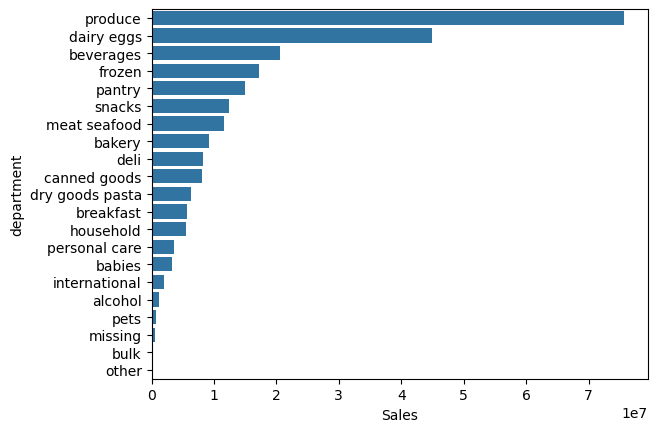

In [11]:
# Create bar plot showing total sales by department name
deptsalesbar = sns.barplot(y = 'department', x = 'prices', data = df_deptsales)
deptsalesbar.set_xlabel('Sales')

In [86]:
# Group number of orders by hour of day, save as dataframe
hourcount = df.groupby(['order_hour_of_day'])['order_id'].count().to_frame()
print(hourcount)

                   order_id
order_hour_of_day          
0                    218766
1                    115699
2                     69374
3                     51281
4                     53241
5                     87959
6                    290492
7                    891040
8                   1718100
9                   2454165
10                  2761710
11                  2736075
12                  2618481
13                  2660900
14                  2689086
15                  2662094
16                  2535154
17                  2087609
18                  1636469
19                  1258290
20                   976145
21                   795628
22                   634216
23                   402315


Text(0, 0.5, 'Number of Orders')

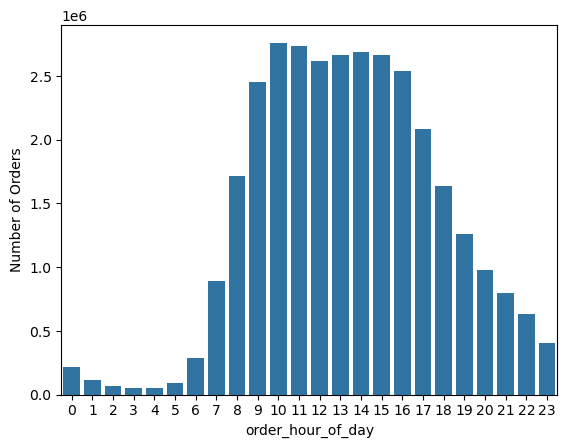

In [88]:
# Create bar chart showing total sales by hour of day
hourlycountbar = sns.barplot(x = 'order_hour_of_day', y = 'order_id', data = hourcount)
hourlycountbar.set_ylabel('Number of Orders')

In [81]:
# Group number of orders by hour of day, save as dataframe
dowcount = df.groupby(['order_dow'])['order_id'].count().to_frame()
print(dowcount)

           order_id
order_dow          
0           6204040
1           5660135
2           4213760
3           3840476
4           3783754
5           4205721
6           4496403


<function matplotlib.pyplot.show(close=None, block=None)>

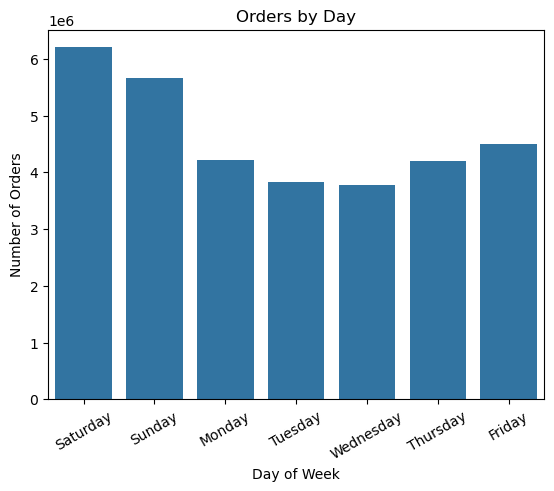

In [83]:
# Create bar chart showing total sales by hour of day
dowcountbar = sns.barplot(x = 'order_dow', y = 'order_id', data = dowcount)
dowcountbar.set_ylabel('Number of Orders')
dowcountbar.set_xlabel('Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
          rotation=30)
plt.title('Orders by Day')
plt.show

## 3. Feature Creation

In [7]:
# Calculate customer-level features
customer_features = df.groupby('user_id').agg(
    order_count=('order_id', 'count'),
    avg_days_between_orders=('days_since_prior_order', 'mean'),
    uniq_prod=('product_id', 'nunique'),
    total_spent=('prices', 'sum'),
    weekend_order_ratio=('order_dow', lambda x: (x.isin([0,1]).mean())
                         )).reset_index()

In [9]:
# Calculate product preferences
dept_preferences = df.groupby(['user_id','department_id']).agg(
    dept_purchases=('product_id','count')
).reset_index()
dept_preferences['dept_rank'] = dept_preferences.groupby('user_id')['dept_purchases'].rank(ascending=False)
preferred_dept = dept_preferences[dept_preferences['dept_rank']==1][['user_id','department_id']]

In [57]:
# Check preferred_dept
print(preferred_dept.shape)
print(preferred_dept.info())

(196139, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 196139 entries, 6 to 2232138
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   user_id        196139 non-null  int64
 1   department_id  196139 non-null  int64
dtypes: int64(2)
memory usage: 4.5 MB
None


In [11]:
# Calculate basket metrics
basket_stats = df.groupby(['user_id','order_id']).agg(
    basket_size=('product_id','count'),
    reorder_ratio=('reordered','mean')
).groupby('user_id').mean().reset_index()

In [61]:
# Check basket_stats
print(basket_stats.shape)
print(basket_stats.info())

(206210, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206210 entries, 0 to 206209
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        206210 non-null  int64  
 1   basket_size    206210 non-null  float64
 2   reorder_ratio  206210 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 4.7 MB
None


In [13]:
# Merge all features
df_final = customer_features.merge(basket_stats, on='user_id').merge(preferred_dept, on='user_id').merge(departments, on='department_id')

In [81]:
# Check df_final
print(df_final.shape)
print(df_final.info())
print(df_final.head())

(196138, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196138 entries, 0 to 196137
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  196138 non-null  int64  
 1   order_count              196138 non-null  int64  
 2   avg_days_between_orders  196137 non-null  float64
 3   uniq_prod                196138 non-null  int64  
 4   total_spent              196138 non-null  float64
 5   weekend_order_ratio      196138 non-null  float64
 6   basket_size              196138 non-null  float64
 7   reorder_ratio            196138 non-null  float64
 8   department_id            196138 non-null  int64  
 9   department               196138 non-null  object 
dtypes: float64(5), int64(4), object(1)
memory usage: 15.0+ MB
None
   user_id  order_count  avg_days_between_orders  uniq_prod  total_spent  \
0        1           59                20.259259         18        375.7

In [15]:
# Merge with customer data
customer_details = df_final.merge(customer, on='user_id')
print(customer_details.shape)
print(customer_details.info())

(196138, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196138 entries, 0 to 196137
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  196138 non-null  int64  
 1   order_count              196138 non-null  int64  
 2   avg_days_between_orders  196137 non-null  float64
 3   uniq_prod                196138 non-null  int64  
 4   total_spent              196138 non-null  float64
 5   weekend_order_ratio      196138 non-null  float64
 6   basket_size              196138 non-null  float64
 7   reorder_ratio            196138 non-null  float64
 8   department_id            196138 non-null  int64  
 9   department               196138 non-null  object 
 10  First Name               185423 non-null  object 
 11  Surnam                   196138 non-null  object 
 12  Gender                   196138 non-null  object 
 13  STATE                    196138 non-null  obje

In [140]:
# Check for NaN
customer_details.isnull().sum()

user_id                        0
order_count                    0
avg_days_between_orders        1
uniq_prod                      0
total_spent                    0
weekend_order_ratio            0
basket_size                    0
reorder_ratio                  0
department_id                  0
department                     0
First Name                 10715
Surnam                         0
Gender                         0
STATE                          0
Age                            0
date_joined                    0
n_dependants                   0
fam_status                     0
income                         0
dtype: int64

In [17]:
# Filter out NaN
customer_details_clean = customer_details[customer_details['avg_days_between_orders'].isnull()==False]

## 4. Demographic Analysis

In [27]:
# Create age_grp column
customer_details_clean.loc[customer_details['Age']<=25, 'age_grp'] = '25 and under'

In [29]:
customer_details_clean.loc[(customer_details['Age']>25) & (customer_details['Age']<=50), 'age_grp'] = '26-50'

In [31]:
customer_details_clean.loc[(customer_details['Age']>=51) & (customer_details['Age']<75), 'age_grp'] = '51-74'

In [33]:
customer_details_clean.loc[customer_details['Age']>=75, 'age_grp'] = '75 and over'

In [35]:
# Select relevant columns for age_grp analysis
avgs_by_age = customer_details_clean[['age_grp', 'order_count','avg_days_between_orders', 'weekend_order_ratio', 'Age', 'income', 'total_spent', 'uniq_prod',
              'basket_size','reorder_ratio']]
# Analyze group characteristics
profiles = avgs_by_age.groupby('age_grp').mean().round(2)
print(profiles)

              order_count  avg_days_between_orders  weekend_order_ratio  \
age_grp                                                                   
25 and under       162.86                    15.31                 0.36   
26-50              162.85                    15.35                 0.36   
51-74              161.63                    15.32                 0.36   
75 and over        162.52                    15.24                 0.36   

                Age     income  total_spent  uniq_prod  basket_size  \
age_grp                                                               
25 and under  21.48   67665.78      1268.03      66.32        10.10   
26-50         38.01   84770.82      1268.96      66.20        10.06   
51-74         62.48  109912.22      1259.45      65.86        10.07   
75 and over   77.99  110319.03      1265.90      66.47        10.07   

              reorder_ratio  
age_grp                      
25 and under           0.46  
26-50                  0.46  
51

In [47]:
spent_by_age = customer_details_clean.groupby(['age_grp'])['total_spent'].sum().to_frame().reset_index()

spent_by_age.head()

,age_grp,total_spent
0,25 and under,30948792.6
1,26-50,97362320.0
2,51-74,92459667.7
3,75 and over,27332092.3


Axes(0.125,0.11;0.775x0.77)


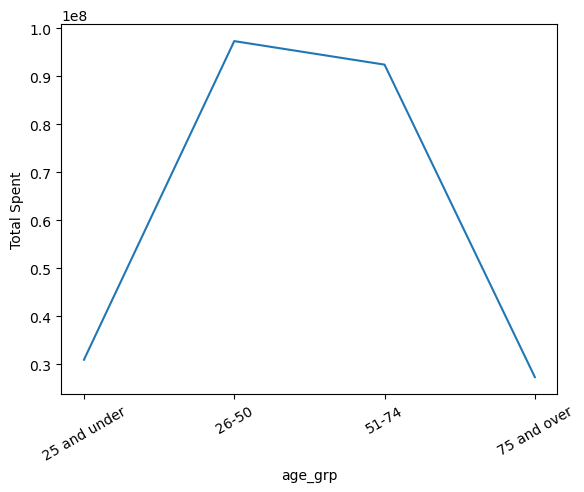

In [51]:
# Create line chart
line = sns.lineplot(data = spent_by_age, x = 'age_grp',y = 'total_spent')
plt.ylabel('Total Spent')
plt.xticks(rotation=30)
print(line)

In [71]:
avg_spent_by_age = customer_details_clean.groupby(['age_grp'])['total_spent'].mean().to_frame().reset_index()

avg_spent_by_age.head()

,age_grp,total_spent
0,25 and under,1268.029360
1,26-50,1268.961239
2,51-74,1259.445435
3,75 and over,1265.902103


Axes(0.125,0.11;0.775x0.77)


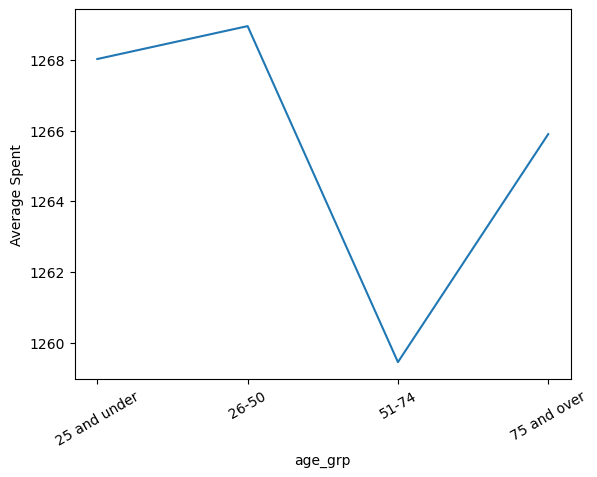

In [75]:
# Create line chart
line = sns.lineplot(data = avg_spent_by_age, x = 'age_grp',y = 'total_spent')
plt.ylabel('Average Spent')
plt.xticks(rotation=30)
print(line)

In [76]:
# Get top 2 departments per age group
top_depts_per_age_grp = (customer_details_clean.groupby(['age_grp', 'department'])
                         .size()
                         .reset_index(name='count')
                         .sort_values(['age_grp', 'count'], ascending=[True, False])
                         .groupby('age_grp')
                         .head(2))
# Pivot for clean presentation
result = (top_depts_per_age_grp.pivot(index='age_grp', 
                                    columns='department', 
                                    values='count')
                              .fillna('')
                              .apply(lambda x: x.sort_values(ascending=False).index[:2], axis=1)
                              .reset_index(name='top_departments'))

# Format output
result['top_departments'] = result['top_departments'].apply(lambda x: f"{x[0]}, {x[1]}")

print("Top 2 Departments per Age Group:")
print(result.to_markdown(index=False))

Top 2 Departments per Age Group:
| age_grp      | top_departments     |
|:-------------|:--------------------|
| 25 and under | produce, dairy eggs |
| 26-50        | produce, dairy eggs |
| 51-74        | produce, dairy eggs |
| 75 and over  | produce, dairy eggs |


In [53]:
# Create income_grp column
customer_details_clean.loc[customer_details['income']<100000, 'income_grp'] = '0 - 100k'

In [55]:
customer_details_clean.loc[(customer_details['income']>=100000) & (customer_details['income']<200000), 'income_grp'] = '100k - 200k'

In [57]:
customer_details_clean.loc[(customer_details['income']>=200000) & (customer_details['income']<300000), 'income_grp'] = '200k - 300k'

In [59]:
customer_details_clean.loc[customer_details['income']>=300000, 'income_grp'] = '300k+'

In [61]:
spent_by_income = customer_details_clean.groupby(['income_grp'])['total_spent'].sum().to_frame().reset_index()

spent_by_income.head()

,income_grp,total_spent
0,0 - 100k,132171981.1
1,100k - 200k,113976994.0
2,200k - 300k,1193469.4
3,300k+,760428.1


Axes(0.125,0.11;0.775x0.77)


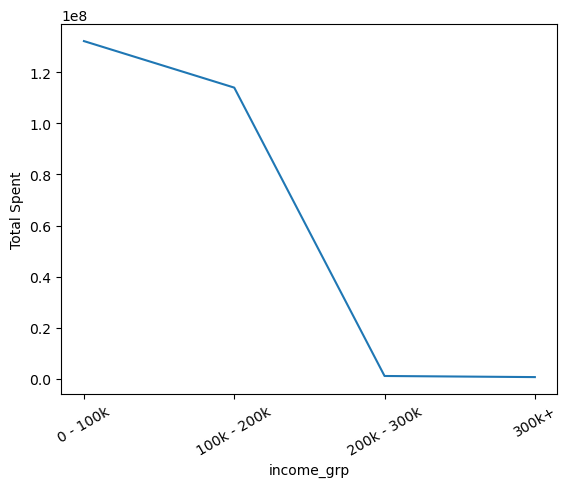

In [63]:
# Create line chart
line = sns.lineplot(data = spent_by_income, x = 'income_grp',y = 'total_spent')
plt.ylabel('Total Spent')
plt.xticks(rotation=30)
print(line)

In [65]:
avg_spent_by_income = customer_details_clean.groupby(['income_grp'])['total_spent'].mean().to_frame().reset_index()

avg_spent_by_income.head()

,income_grp,total_spent
0,0 - 100k,1171.820529
1,100k - 200k,1383.467791
2,200k - 300k,2005.830924
3,300k+,2083.364658


Axes(0.125,0.11;0.775x0.77)


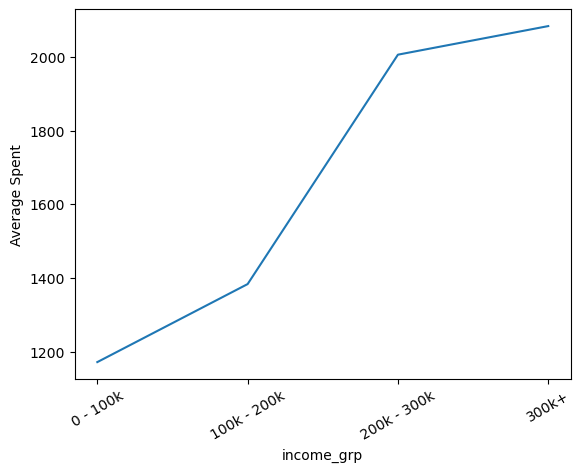

In [69]:
line = sns.lineplot(data = avg_spent_by_income, x = 'income_grp',y = 'total_spent')
plt.ylabel('Average Spent')
plt.xticks(rotation=30)
print(line)

In [43]:
# Select relevant columns for income_grp analysis
avgs_by_income = customer_details_clean[['income_grp', 'order_count','avg_days_between_orders', 'weekend_order_ratio', 'Age', 'income', 'total_spent', 'uniq_prod',
              'basket_size','reorder_ratio']]
# Analyze group characteristics
profiles2 = avgs_by_income.groupby('income_grp').mean().round(2)
print(profiles2)

             order_count  avg_days_between_orders  weekend_order_ratio    Age  \
income_grp                                                                      
0 - 100k          153.15                    15.49                 0.36  41.55   
100k - 200k       173.78                    15.11                 0.36  60.35   
200k - 300k       260.04                    13.24                 0.35  57.04   
300k+             271.35                    13.38                 0.34  52.22   

                income  total_spent  uniq_prod  basket_size  reorder_ratio  
income_grp                                                                  
0 - 100k      65599.61      1171.82      61.83         9.65           0.47  
100k - 200k  132396.06      1383.47      71.50        10.62           0.46  
200k - 300k  249977.45      2005.83     104.63        12.39           0.49  
300k+        414331.11      2083.36     113.59        12.49           0.48  


In [80]:
# Get top 2 departments per income group
top_depts_per_income_grp = (customer_details_clean.groupby(['income_grp', 'department'])
                         .size()
                         .reset_index(name='count')
                         .sort_values(['income_grp', 'count'], ascending=[True, False])
                         .groupby('income_grp')
                         .head(2))
# Pivot for clean presentation
result = (top_depts_per_income_grp.pivot(index='income_grp', 
                                    columns='department', 
                                    values='count')
                              .fillna('')
                              .apply(lambda x: x.sort_values(ascending=False).index[:2], axis=1)
                              .reset_index(name='top_departments'))

# Format output
result['top_departments'] = result['top_departments'].apply(lambda x: f"{x[0]}, {x[1]}")

print("Top 2 Departments per Income Group:")
print(result.to_markdown(index=False))

Top 2 Departments per Income Group:
| income_grp   | top_departments     |
|:-------------|:--------------------|
| 0 - 100k     | produce, dairy eggs |
| 100k - 200k  | produce, dairy eggs |
| 200k - 300k  | produce, dairy eggs |
| 300k+        | produce, dairy eggs |


## 5. Clustering Analysis

In [19]:
# Feature selection
features = customer_details_clean[['order_count','avg_days_between_orders', 'weekend_order_ratio', 'basket_size', 'uniq_prod', 'reorder_ratio', 'Age', 'income']]

# One-hot encode departments
#features = pd.get_dummies(features, columns=['department'])

In [21]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [23]:
# PCA for dimensionality reduction
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

In [25]:
# Determine optimal clusters
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

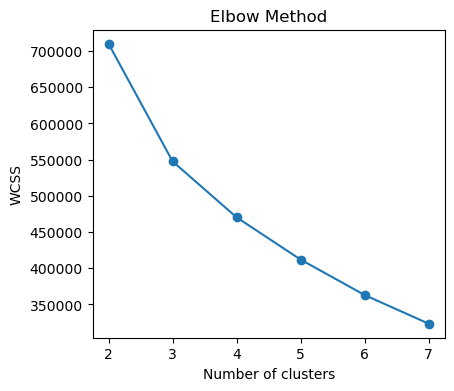

In [111]:
# Plot elbow curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(2,8), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [27]:
# Final clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_details_clean['cluster'] = kmeans.fit_predict(pca_features)

## 6. Cluster Profiling

In [29]:
# Create a DataFrame of scaled features with cluster labels
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['cluster'] = customer_details_clean['cluster']

In [57]:
print(scaled_df.shape)
print(scaled_df.info())

(196137, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196137 entries, 0 to 196136
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_count              196137 non-null  float64
 1   avg_days_between_orders  196137 non-null  float64
 2   weekend_order_ratio      196137 non-null  float64
 3   basket_size              196137 non-null  float64
 4   uniq_prod                196137 non-null  float64
 5   reorder_ratio            196137 non-null  float64
 6   Age                      196137 non-null  float64
 7   income                   196137 non-null  float64
 8   cluster                  196136 non-null  float64
dtypes: float64(9)
memory usage: 13.5 MB
None


In [31]:
# Calculate mean scaled values per cluster
scaled_profiles = scaled_df.groupby('cluster').mean().round(2)

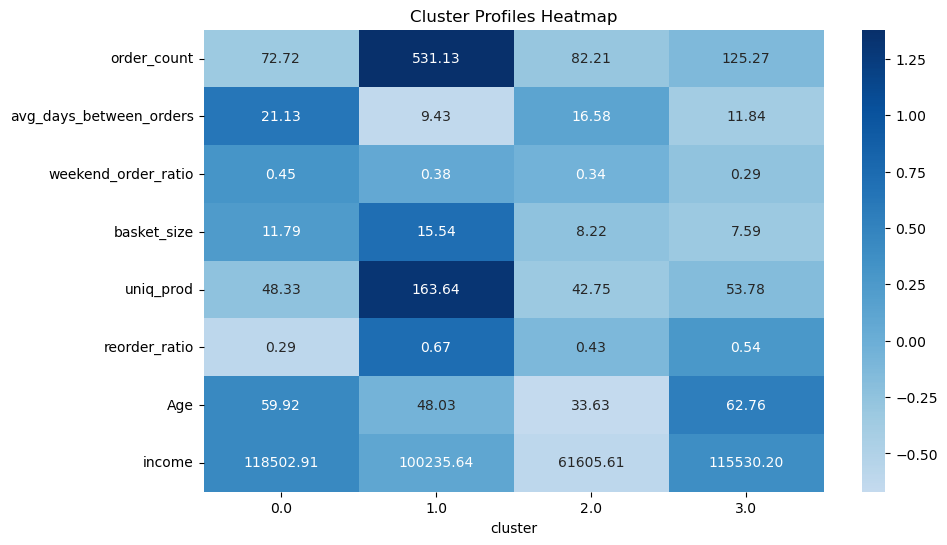

In [33]:
# Analyze cluster characteristics
cluster_profiles = customer_details_clean.groupby('cluster').agg({
    'order_count':'mean',
    'avg_days_between_orders':'mean',
    'weekend_order_ratio':'mean',
    'basket_size':'mean',
    'uniq_prod':'mean',
    'reorder_ratio':'mean',
    'Age':'mean',
    'income':'mean'
}).round(2)


# Visualize profiles
plt.figure(figsize=(10,6))
sns.heatmap(
    scaled_profiles.T,  # Use scaled values for coloring
    annot=cluster_profiles.T,  # Use original values for annotations
    cmap='Blues', 
    fmt='.2f',  # Treat annotations as strings
    annot_kws={'size': 10},
    center=0  # Center color map at 0 (since data is standardized)
)
plt.title('Cluster Profiles Heatmap')
plt.show()

In [35]:
# Compare cluster sizes
print(customer_details_clean['cluster'].value_counts().sort_index())

cluster
0    46484
1    31249
2    68864
3    49540
Name: count, dtype: int64


In [37]:
# Get top 2 departments per cluster
top_depts_per_cluster = (customer_details_clean.groupby(['cluster', 'department'])
                         .size()
                         .reset_index(name='count')
                         .sort_values(['cluster', 'count'], ascending=[True, False])
                         .groupby('cluster')
                         .head(2))
# Pivot for clean presentation
result = (top_depts_per_cluster.pivot(index='cluster', 
                                    columns='department', 
                                    values='count')
                              .fillna('')
                              .apply(lambda x: x.sort_values(ascending=False).index[:2], axis=1)
                              .reset_index(name='top_departments'))

# Format output
result['top_departments'] = result['top_departments'].apply(lambda x: f"{x[0]}, {x[1]}")

print("Top 2 Departments per Cluster:")
print(result.to_markdown(index=False))

Top 2 Departments per Cluster:
|   cluster | top_departments     |
|----------:|:--------------------|
|         0 | produce, dairy eggs |
|         1 | produce, dairy eggs |
|         2 | produce, dairy eggs |
|         3 | produce, dairy eggs |


## 7. Business Recommendations

In [125]:
# Define segment strategies
strategies = {

    0: {
        'name': 'Bulk Shoppers',
        'characteristics': 'Large baskets, less frequent orders, weekend buyers',
        'strategy': 'Volume discounts and bulk promotions'
    },
    1: {
        'name': 'Impulse Buyers',
        'characteristics': 'Frequent, large orders, diverse products',
        'strategy': 'New product recommendations'
    },
    2: {
        'name': 'Convenience Shoppers',
        'characteristics': 'Small, infrequent orders, low planning',
        'strategy': 'Push notifications for quick reorders'
    },
    3: {

        'name': 'Meal Planners',
        'characteristics': 'High reorder ratio, consistent basket size',
        'strategy': 'Subscription program for staples'
    }
}

# Display recommendations
for cluster, strategy in strategies.items():
    print(f"\n**{strategy['name']} (Cluster {cluster})**")
    print(f"- Characteristics: {strategy['characteristics']}")
    print(f"- Recommended Strategy: {strategy['strategy']}")


**Bulk Shoppers (Cluster 0)**
- Characteristics: Large baskets, less frequent orders, weekend buyers
- Recommended Strategy: Volume discounts and bulk promotions

**Impulse Buyers (Cluster 1)**
- Characteristics: Frequent, large orders, diverse products
- Recommended Strategy: New product recommendations

**Convenience Shoppers (Cluster 2)**
- Characteristics: Small, infrequent orders, low planning
- Recommended Strategy: Push notifications for quick reorders

**Meal Planners (Cluster 3)**
- Characteristics: High reorder ratio, consistent basket size
- Recommended Strategy: Subscription program for staples
